In [1]:
import os

import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

import sklearn
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_kernels
import graphtools
#from pydiffmap.diffusion_map import DiffusionMap
import phate

os.chdir('..')
from diffusion_maps import compute_dm, plot_change_in_diffusion_distance, compute_diffusion_distance_direct, compute_diffusion_distance_using_dmcoords, display_powers_of_diff_op
from graph_utils import get_graph_representation, plot_graph, get_groups_from_graph
import manifold_methods
import plotting
import mappings
import data_loader

Load 1000G

In [2]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [3]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]

# make labels
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]
class_label_names = [str(label)[2:-1] for label in class_label_names]
label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

In [4]:
# For visualization of diffusion operator, will want to order by class!
new_order = []
labs_arr = np.array(label_with_names)
for lab in mappings.label_order_1000G_fine:
    new_order = new_order + np.arange(len(labs_arr))[lab == labs_arr].tolist()

In [5]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

G = graphtools.Graph(pca_input, n_pca=None, n_landmark=None)
K = G.kernel
K = np.array(K.todense())
P = G.diff_op
P_arr = np.array(P.todense())[new_order][:,new_order]

Look at Disconnections in directed graph

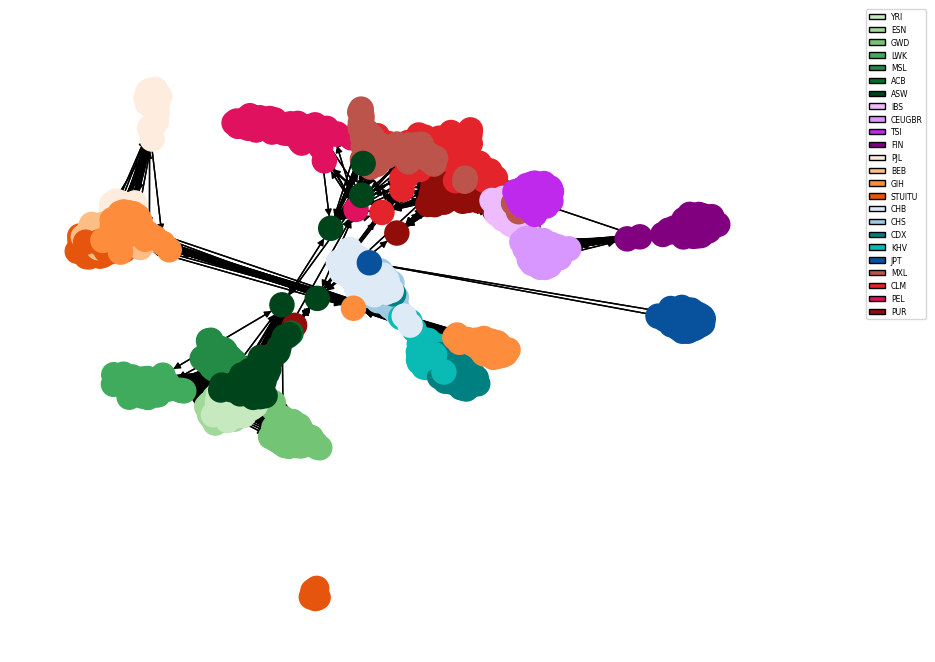

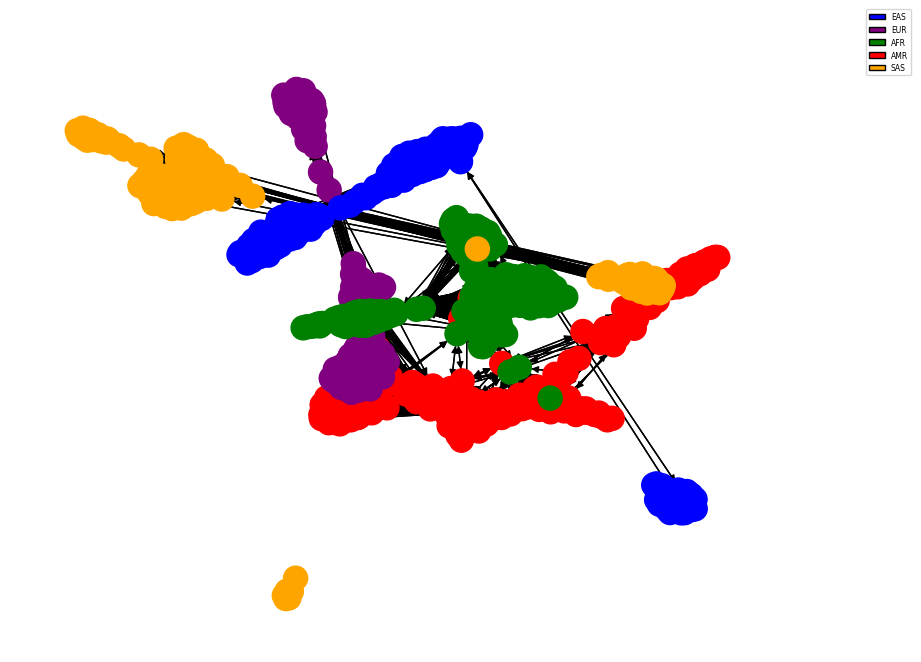

In [8]:
labels_dict = {'pop_label': label_with_names,
               'superpop_label': label_with_superpop_names}
palettes = {'pop_label': mappings.pop_pallette_1000G_fine,
            'superpop_label': mappings.pop_pallette_1000G_coarse}
label_orders = {'pop_label': mappings.label_order_1000G_fine,
                'superpop_label': mappings.label_order_1000G_coarse}

plot_graph(K, labels_dict, palettes, label_orders)

## Describe Disconnected Parts

In [6]:
indices = get_groups_from_graph(K)

In [7]:
for i, group in enumerate(np.unique(indices)):
    names, counts = np.unique(np.array(label_with_names)[indices==group], 
                              return_counts=True)
    print('group {}'.format(i))
    print(pd.DataFrame({'name': names, 'counts':counts}).T)

group 0
         0    1       2    3    4    5    6    7    8    9    10   11   12  \
name    ACB  ASW  CEUGBR  CLM  ESN  FIN  GWD  IBS  LWK  MSL  MXL  PEL  PUR   
counts   96   61     107   94   99   99  113  107   99   85   64   85  104   

         13   14  
name    TSI  YRI  
counts  107  108  
group 1
          0    1    2    3    4
name    CDX  CHB  CHS  JPT  KHV
counts   93  103  105  104   99
group 2
          0    1    2       3
name    BEB  GIH  PJL  STUITU
counts   86  103   96      96
group 3
             0
name    STUITU
counts       9


In [8]:
print(np.char.decode(samples)[indices==group])

['HG03718' 'HG03772' 'HG03773' 'HG03785' 'HG04017' 'HG04023' 'HG04026'
 'HG04054' 'HG04056']


## Compute powers of diff op

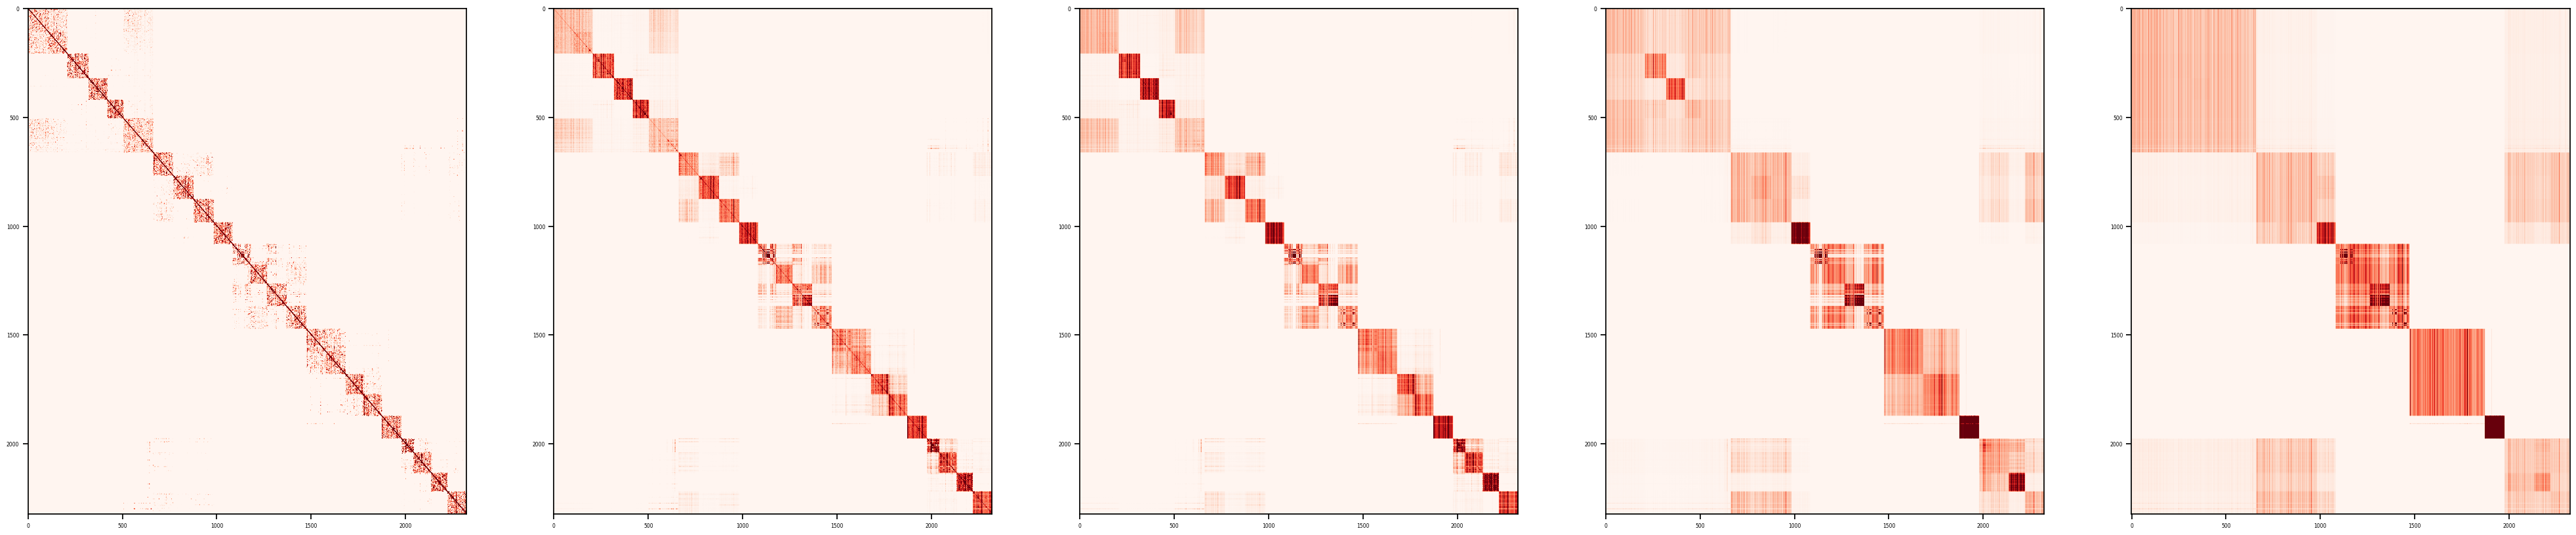

In [9]:
display_powers_of_diff_op(P_arr, [1, 5, 10, 100, 500])

## Diffusion Maps

In [10]:
evecs_right, evals, P, d = compute_dm(K)
diffusion_coords = evecs_right@np.diag(evals)

539 eigenvalues are negative: min=-0.23370330739476336
5 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!


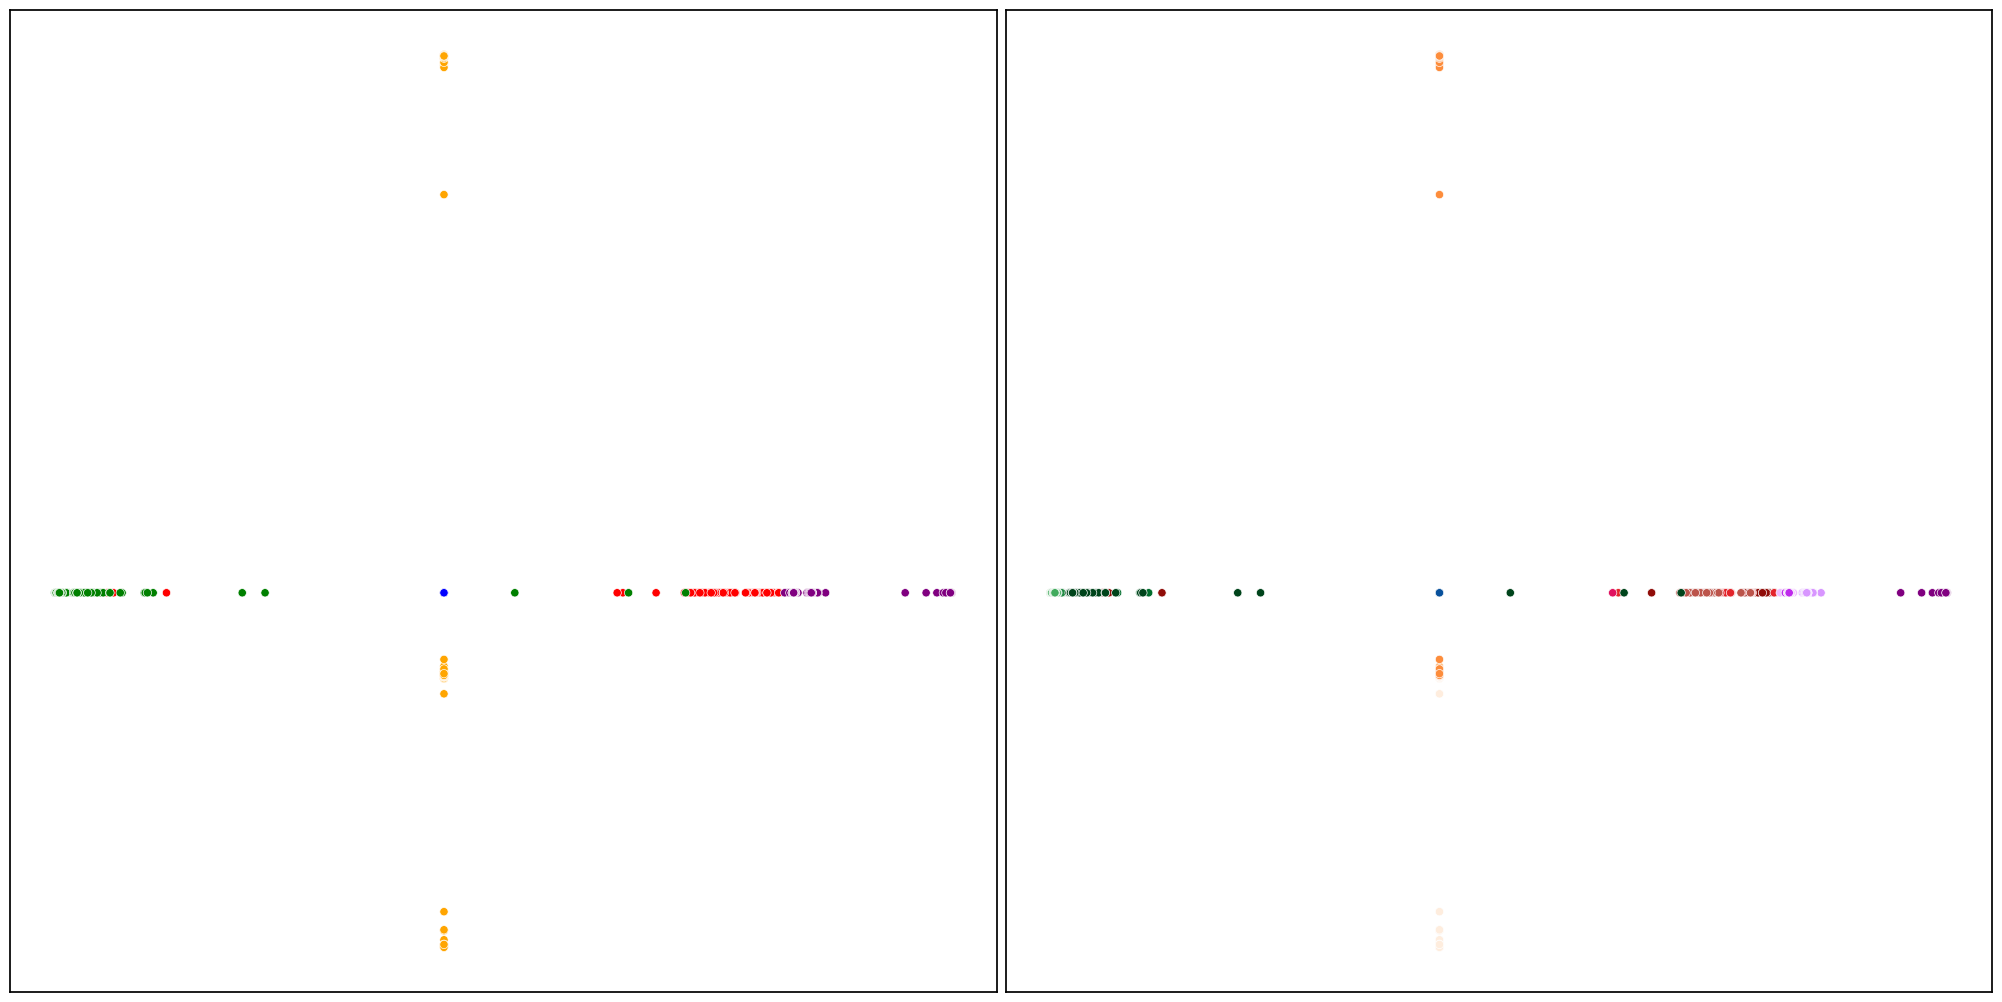

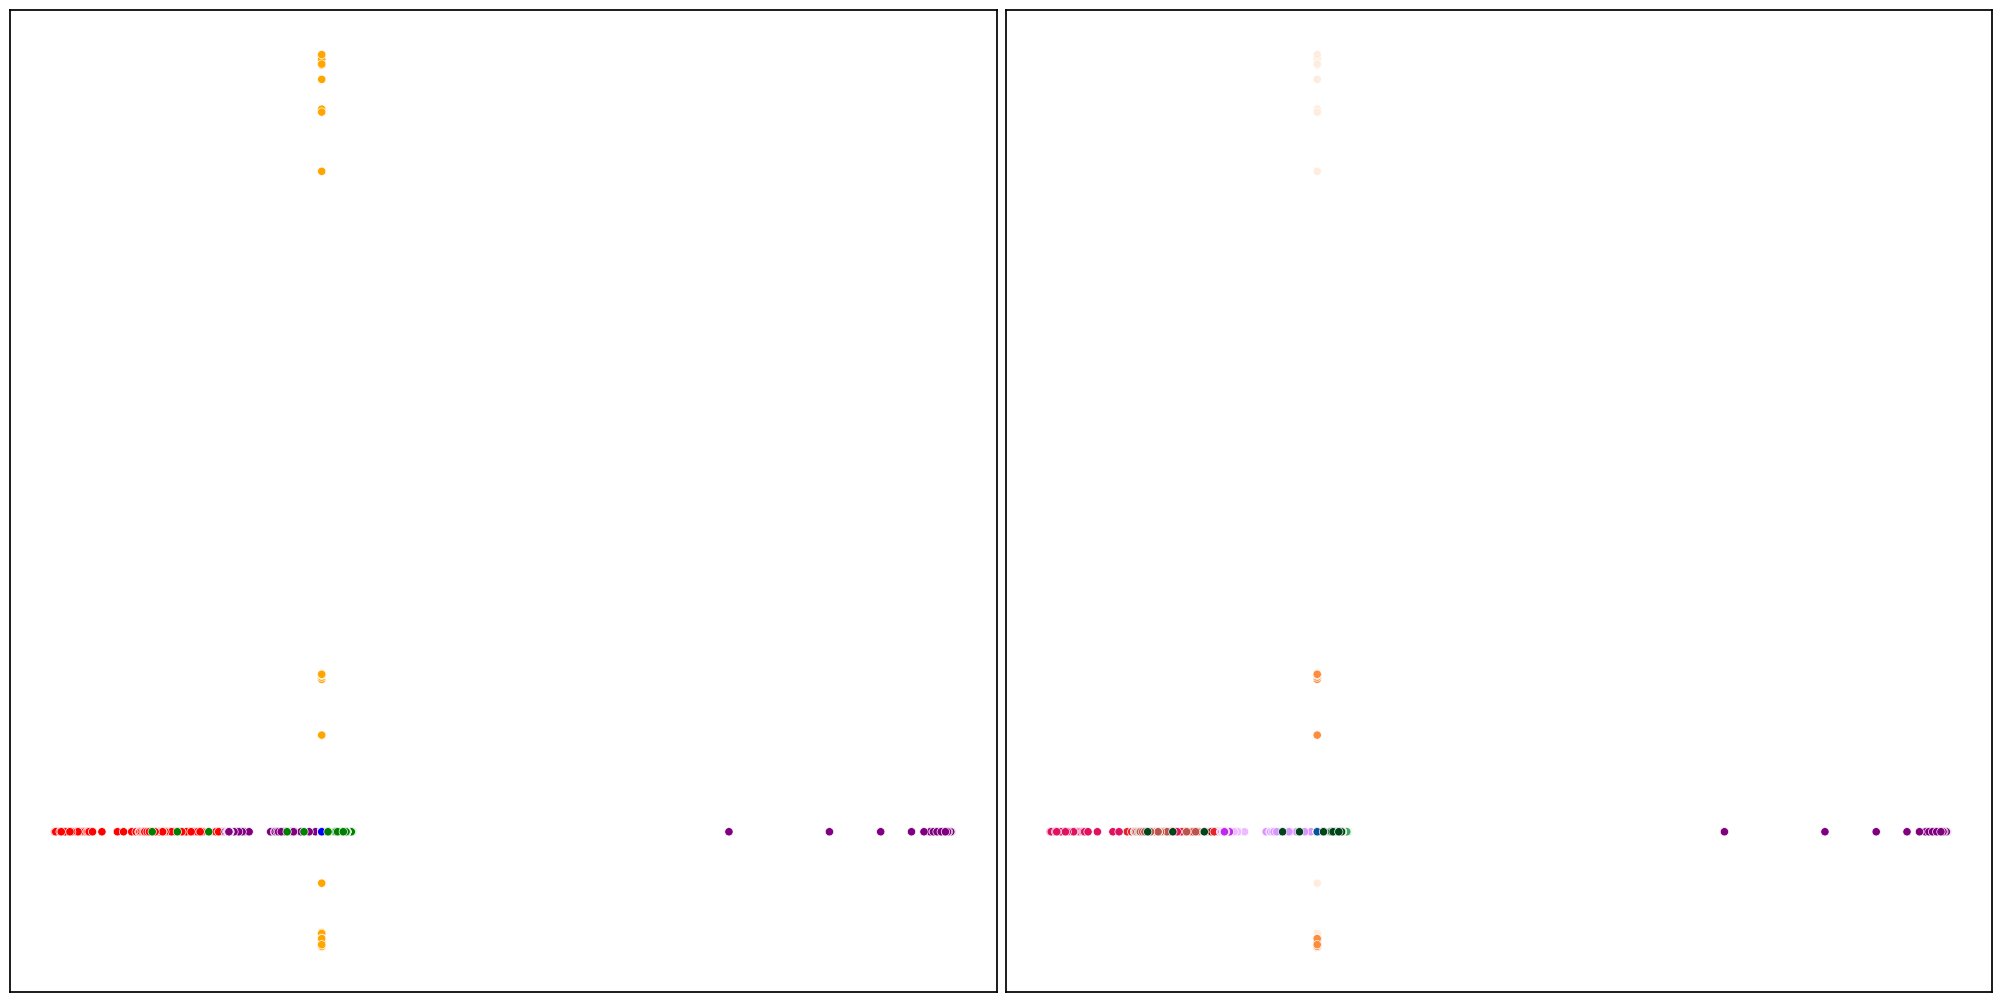

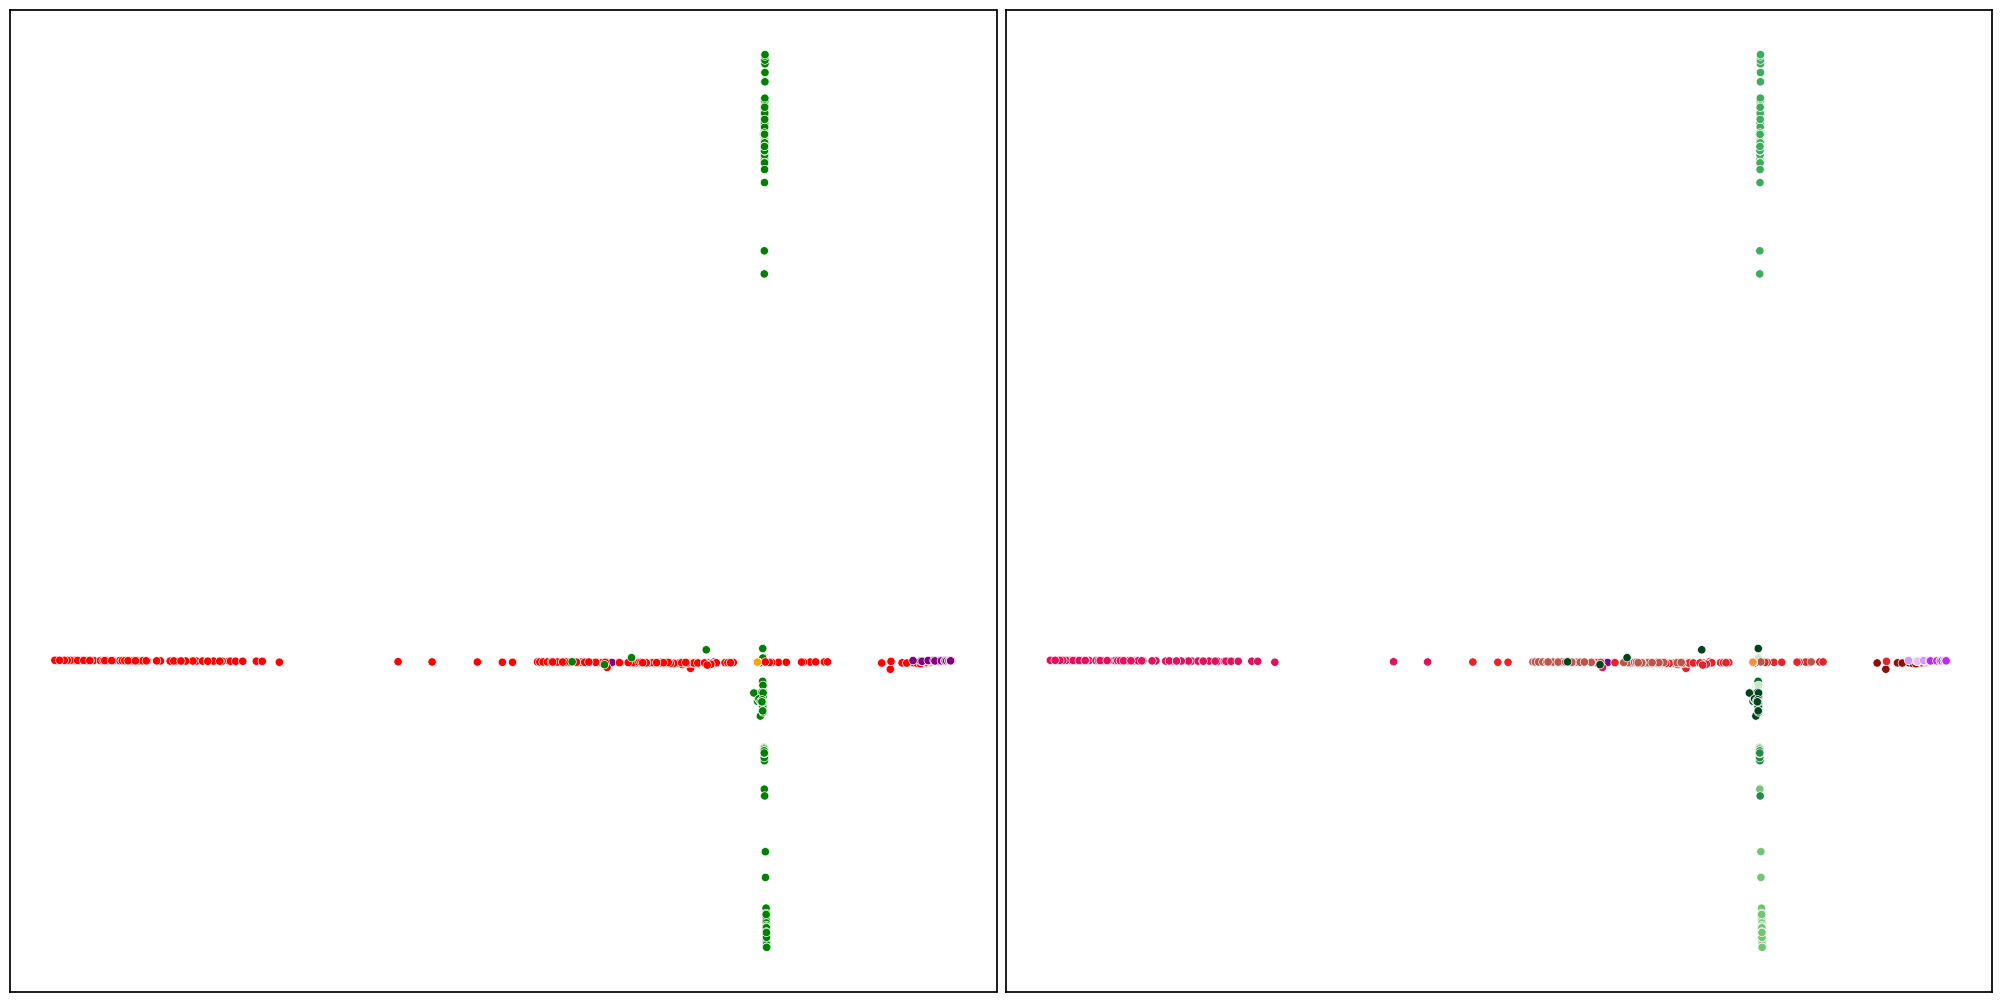

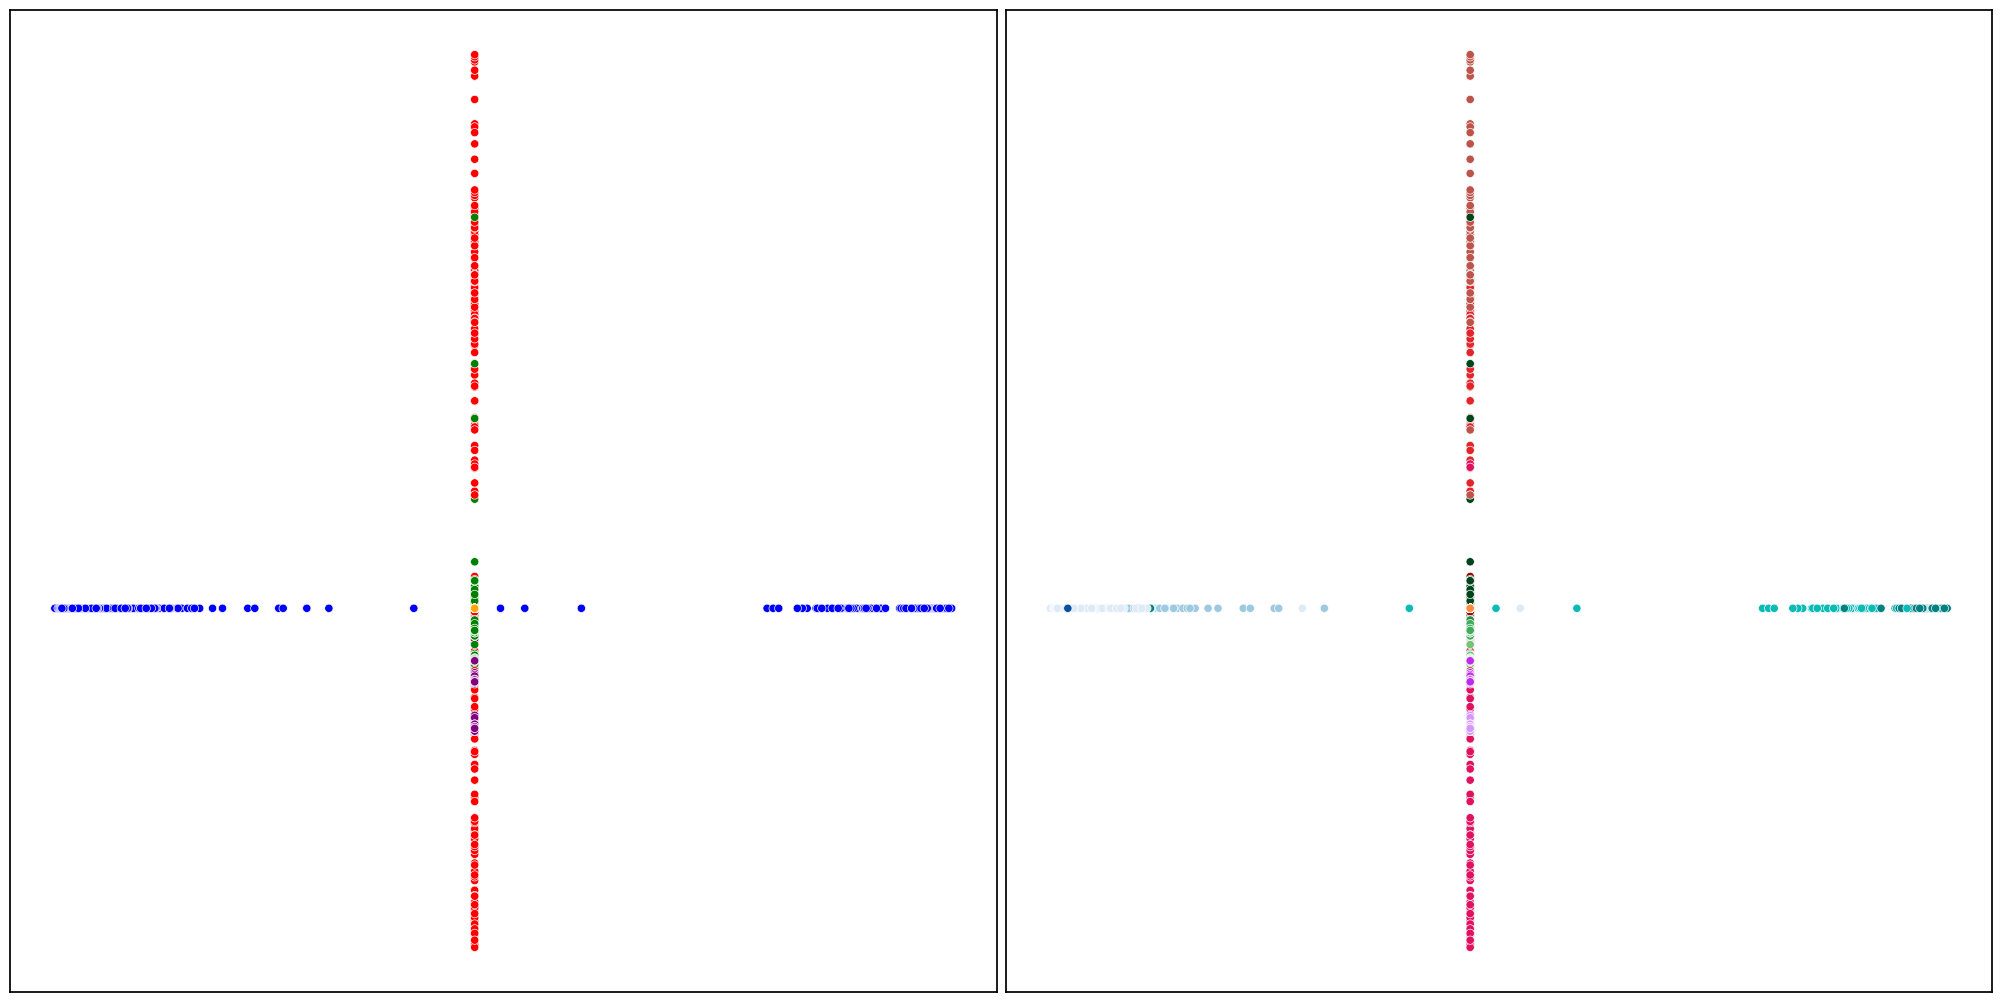

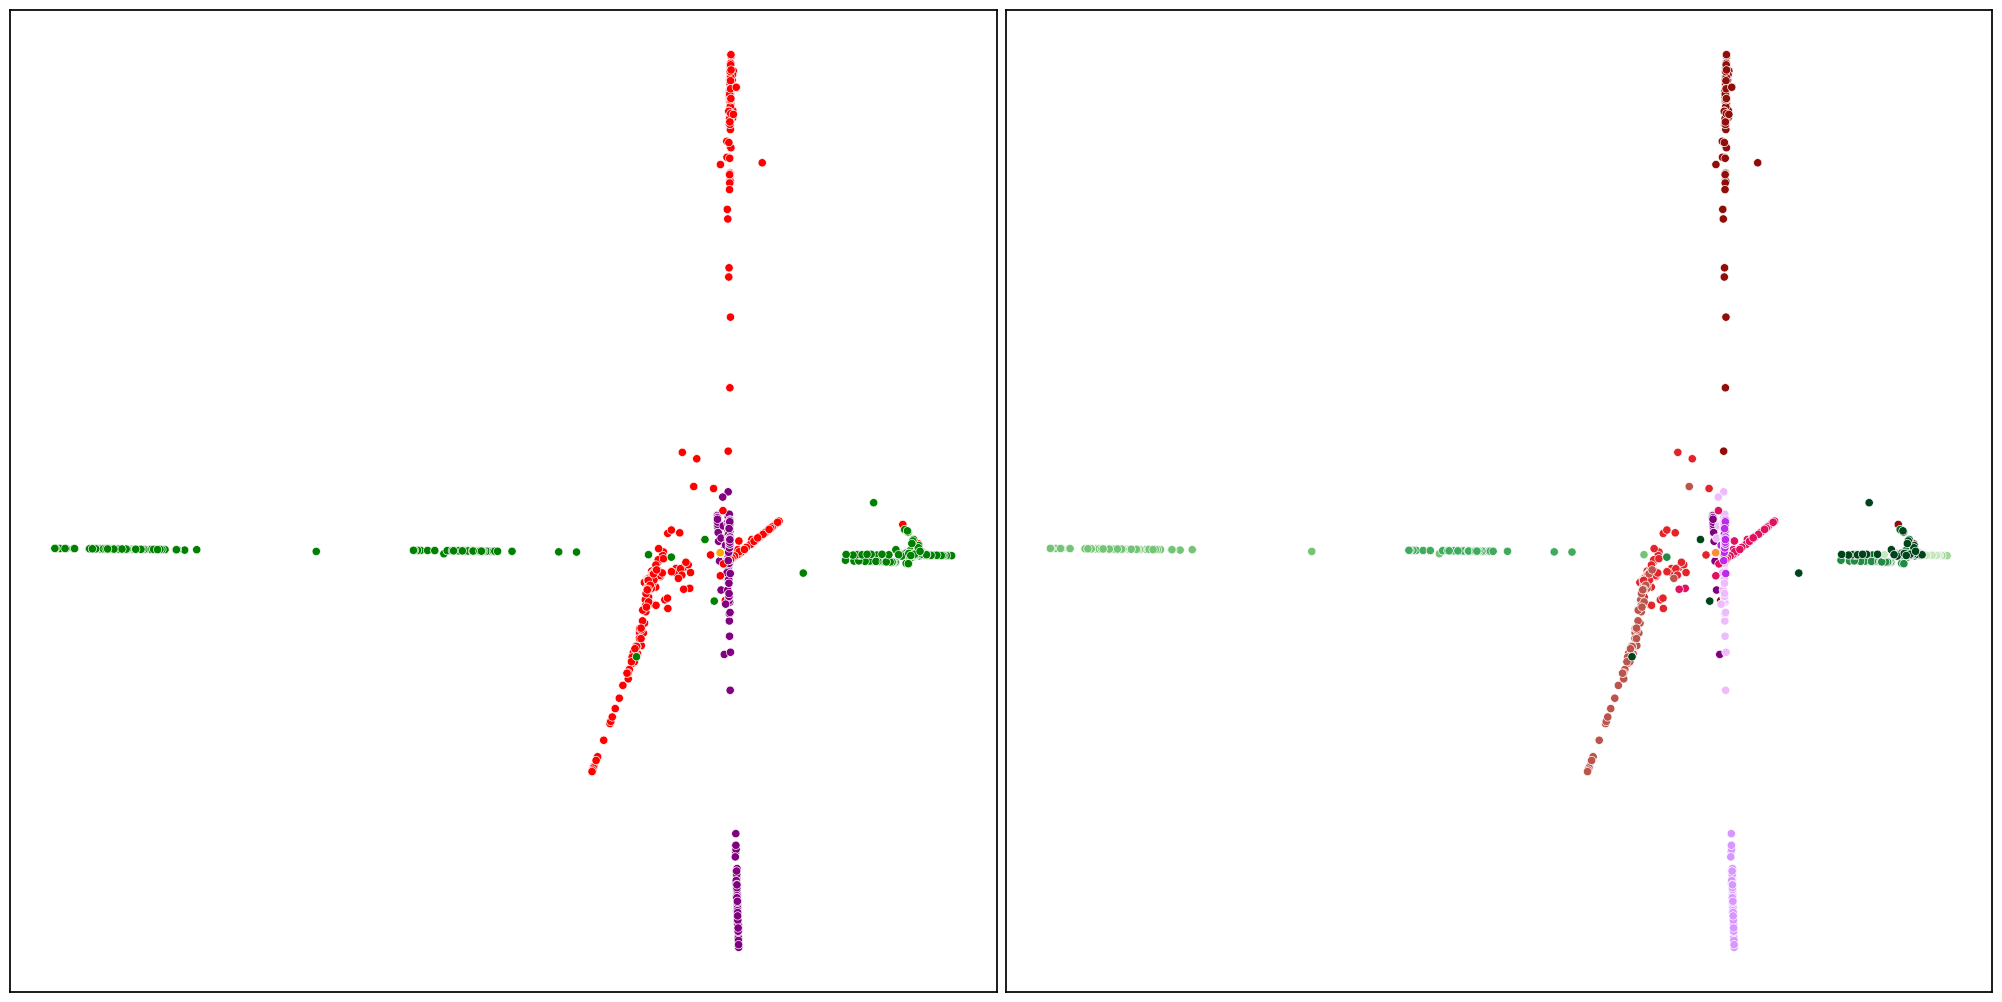

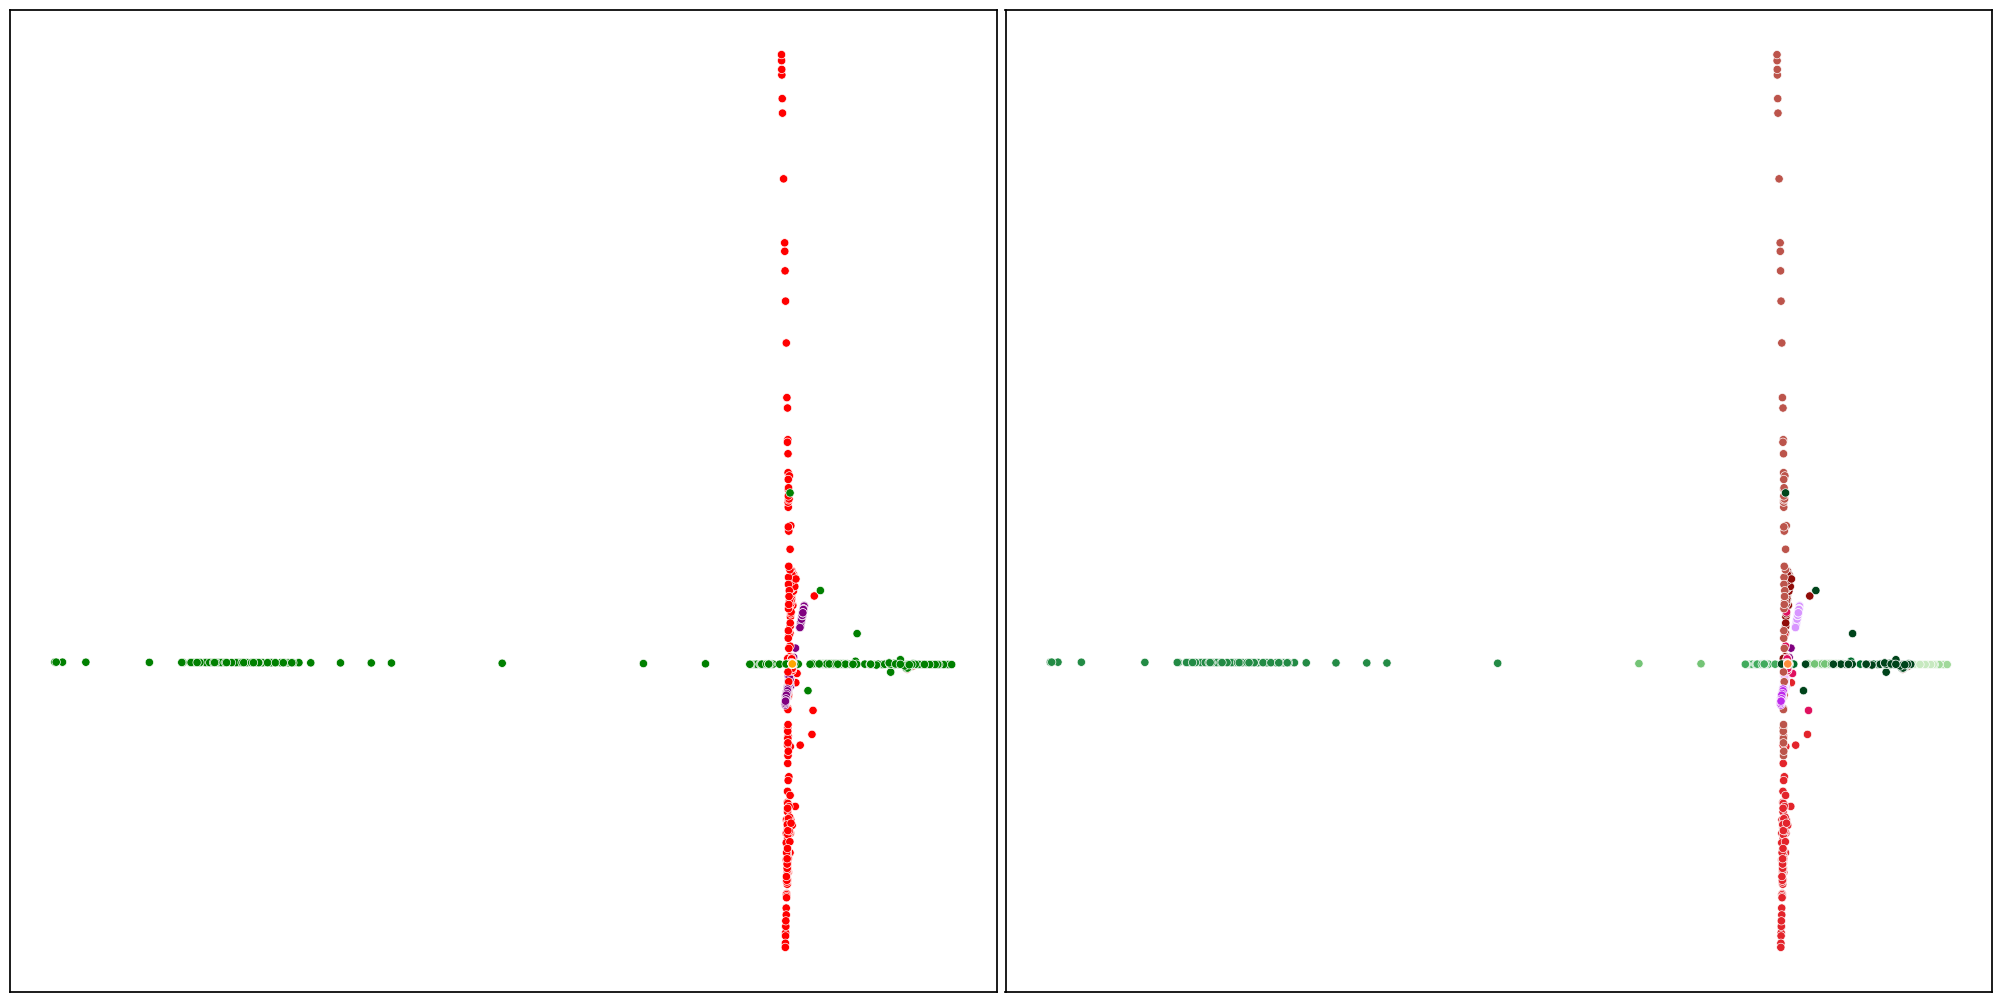

In [13]:
for i in range(5, 16, 2):
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    plotting.plot_embeddings(diffusion_coords[:,i:(i+2)], 
                             np.array(label_with_superpop_names), 
                             None,
                             mappings.pop_pallette_1000G_coarse,
                             mappings.label_order_1000G_coarse,
                             False,
                             ax[0])
    plotting.plot_embeddings(diffusion_coords[:,i:(i+2)], 
                             np.array(label_with_names),
                             None,
                             mappings.pop_pallette_1000G_fine,
                             mappings.label_order_1000G_fine,
                             False,
                             ax[1])
    plt.tight_layout()

## Plot Distortion in Diffusion Distance

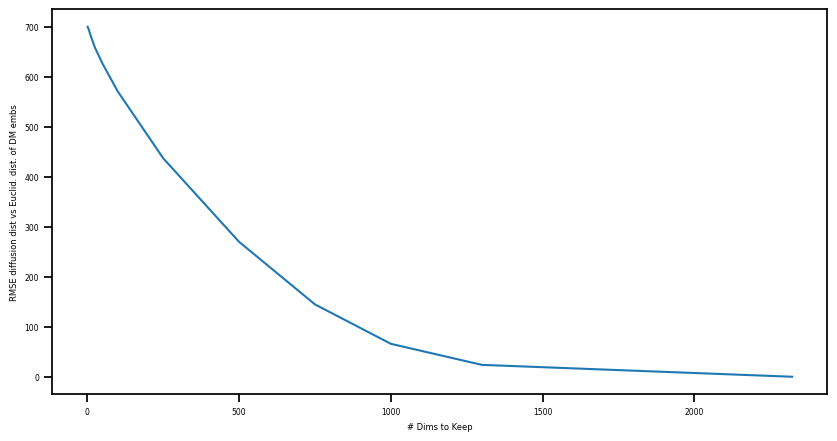

In [14]:
plot_change_in_diffusion_distance(P, 
                                  d/d.sum(), 
                                  diffusion_coords, 
                                  dims_to_plot=[1, 2, 5, 10, 25, 50, 100, 250, 500, 750, 1000, 1300, len(diffusion_coords)])